# LSTM Greenhouse Experiment

This notebook trains and evaluates the LSTM baseline on the greenhouse dataset.

In [1]:
from pathlib import Path
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# Robust path setup to find TPLC_Net and scheme_root
current_dir = Path.cwd()
print(f"Current Working Directory: {current_dir}")

possible_paths = [
    current_dir / '../../TPLC_Net',       # Relative from baselines/LSTM
    current_dir / '../TPLC_Net',          # Relative from baselines
    current_dir / 'TPLC_Net',             # Relative from scheme_1
    Path('d:/degree_code/scheme_1/TPLC_Net') # Absolute fallback
]

tplc_path = None
for p in possible_paths:
    if p.resolve().exists():
        tplc_path = p.resolve()
        break

if tplc_path:
    print(f"Found TPLC_Net at: {tplc_path}")
    if str(tplc_path) not in sys.path:
        sys.path.insert(0, str(tplc_path))
    # Define scheme_root critically for dataset loading
    scheme_root = tplc_path.parent
    print(f"Scheme Root: {scheme_root}")
else:
    raise FileNotFoundError("Could not find TPLC_Net directory. Please check your workspace structure.")

from tplc_algo.pipeline import prepare_greenhouse_datasets, make_loaders
from tplc_algo.train import Trainer, TrainConfig
from tplc_algo.utils import seed_everything
from tplc_algo.exp_utils import create_run_dir, save_metrics_json, save_figure

try:
    from lstm import LSTMForecaster
except ImportError:
    # If custom modules are in current dir
    sys.path.append(str(current_dir))
    from lstm import LSTMForecaster

seed_everything(42)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

Current Working Directory: d:\degree_code\scheme_1\baselines\LSTM
Found TPLC_Net at: D:\degree_code\scheme_1\TPLC_Net
Scheme Root: D:\degree_code\scheme_1


In [2]:
dataset_root = scheme_root / 'datasets' / '自主温室挑战赛'
team = 'AICU'
seq_len = 288
pred_len = 72
stride = 1
batch_size = 32

hidden_dim = 128
num_layers = 2
dropout = 0.1

epochs = 20
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

exp_name = f"lstm_greenhouse_{team}_nb"
run_dir = create_run_dir(exp_name, base_dir=Path('./results'))
print(f"Experiment Dir: {run_dir}")

Experiment Dir: results\lstm_greenhouse_AICU_nb_20260116_164551


In [3]:
prepared = prepare_greenhouse_datasets(
    dataset_root=dataset_root,
    team=team,
    seq_len=seq_len,
    pred_len=pred_len,
    stride=stride,
    missing_rate_threshold=0.7,
    drop_constant=True,
    protect_target_cols=True,
)
train_loader, val_loader, test_loader = make_loaders(prepared, batch_size=batch_size)
print(f"Input Dim: {len(prepared.feature_cols)}")

D:\degree_code\scheme_1\TPLC_Net\tplc_algo\data\greenhouse_dataset.py:32: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Input Dim: 101


In [4]:
model = LSTMForecaster(
    input_dim=len(prepared.feature_cols),
    target_dim=len(prepared.target_cols),
    seq_len=seq_len,
    pred_len=pred_len,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout,
)

In [5]:
trainer = Trainer(
    model=model,
    cfg=TrainConfig(
        epochs=epochs,
        lr=lr,
        device=device,
        ckpt_path=run_dir / 'checkpoints' / 'best.pt',
        early_stop_patience=6,
        show_progress=True
    )
)
history = trainer.fit(train_loader, val_loader=val_loader)

train (epoch):  30%|###       | 6/20 [01:06<02:35, 11.08s/epoch, train=0.0652, val=0.3522, stop=best@1]


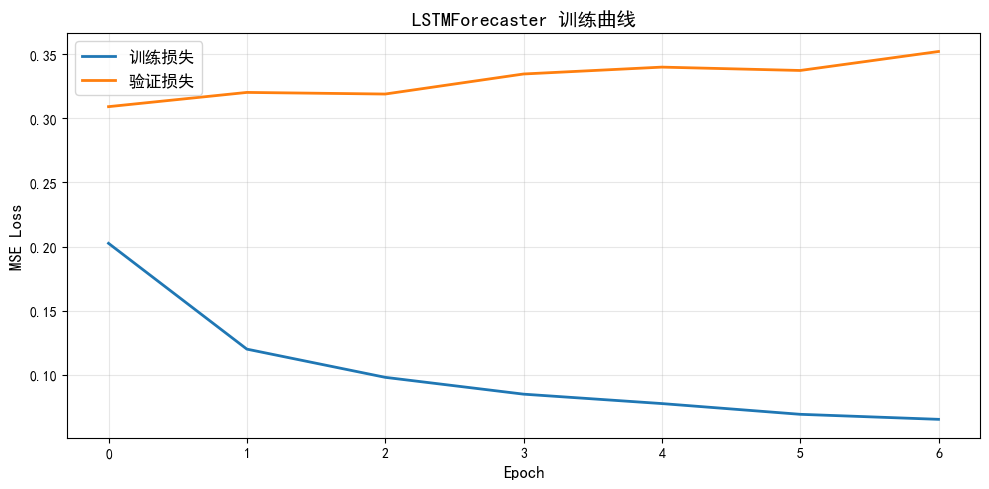

测试集指标（标准化数据）：
  Loss: 1.7325
  MAE:  0.9478
  RMSE: 1.1847

测试集指标（原始尺度）：
  MAE:  59.3181
  RMSE: 118.7244

指标已保存到：results\lstm_greenhouse_AICU_nb_20260116_164551\artifacts\metrics.json


In [7]:
# ========= 5. 训练曲线可视化 =========
fig = plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='训练损失', linewidth=2)
if len(history.get('val_loss', [])) > 0:
    plt.plot(history['val_loss'], label='验证损失', linewidth=2)
plt.legend(fontsize=12)
plt.title(f'{model.__class__.__name__} 训练曲线', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
save_figure(fig, run_dir / 'figures' / 'loss_curve.png')
plt.show()

# ========= 6. 测试集评估 =========
# 确保变量存在
feature_cols = prepared.feature_cols
target_cols = prepared.target_cols
target_scaler = prepared.target_scaler

# 标准化指标
test_metrics = trainer.evaluate(test_loader)
print('测试集指标（标准化数据）：')
print(f"  Loss: {test_metrics['loss']:.4f}")
print(f"  MAE:  {test_metrics['mae']:.4f}")
print(f"  RMSE: {test_metrics['rmse']:.4f}")

# 反标准化指标（更直观）
model.eval()
y_true_list = []
y_pred_list = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y_hat = model(x).cpu().numpy()
        y_true_list.append(y.numpy())
        y_pred_list.append(y_hat)

y_true = np.concatenate(y_true_list, axis=0)  # [N, pred_len, target_dim]
y_pred = np.concatenate(y_pred_list, axis=0)

# 反标准化
y_true_raw = target_scaler.inverse_transform(
    y_true.reshape(-1, len(target_cols))
).reshape(y_true.shape)
y_pred_raw = target_scaler.inverse_transform(
    y_pred.reshape(-1, len(target_cols))
).reshape(y_pred.shape)

test_metrics['mae_raw'] = float(np.mean(np.abs(y_true_raw - y_pred_raw)))
test_metrics['rmse_raw'] = float(np.sqrt(np.mean((y_true_raw - y_pred_raw) ** 2)))

print('\n测试集指标（原始尺度）：')
print(f"  MAE:  {test_metrics['mae_raw']:.4f}")
print(f"  RMSE: {test_metrics['rmse_raw']:.4f}")

save_metrics_json(run_dir, test_metrics)
print(f'\n指标已保存到：{run_dir / "artifacts" / "metrics.json"}')

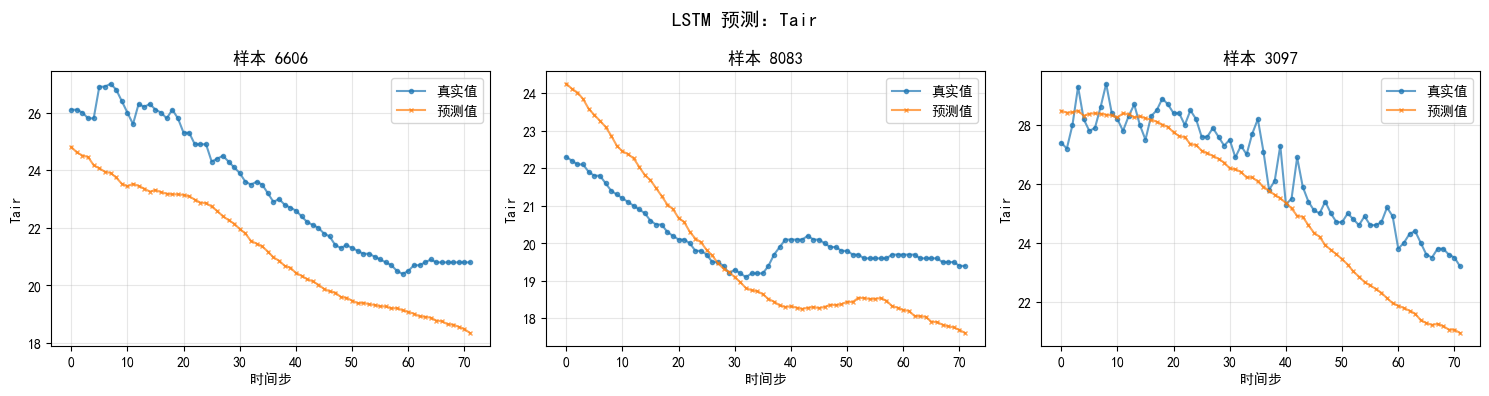

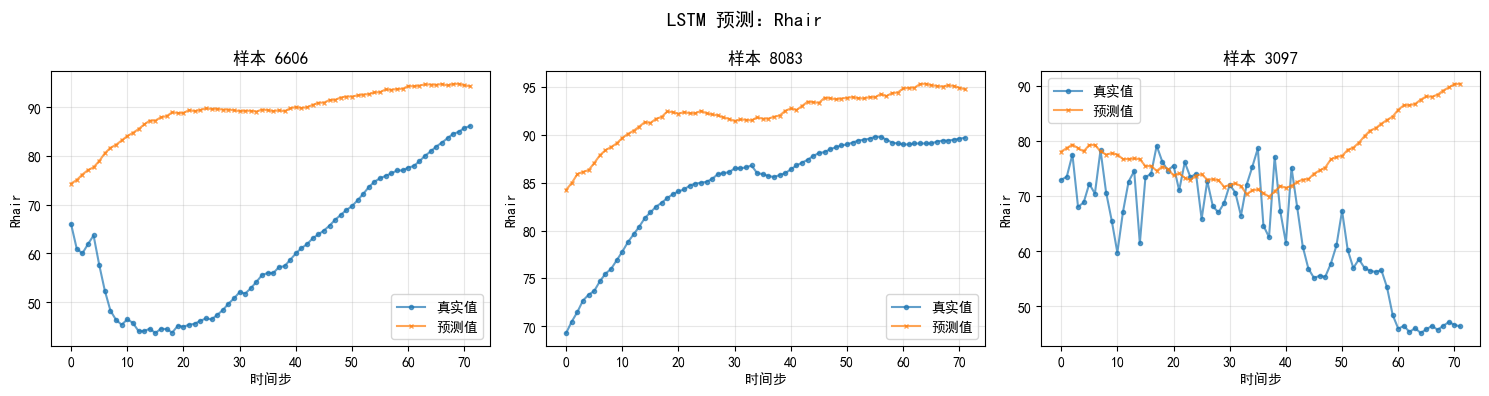

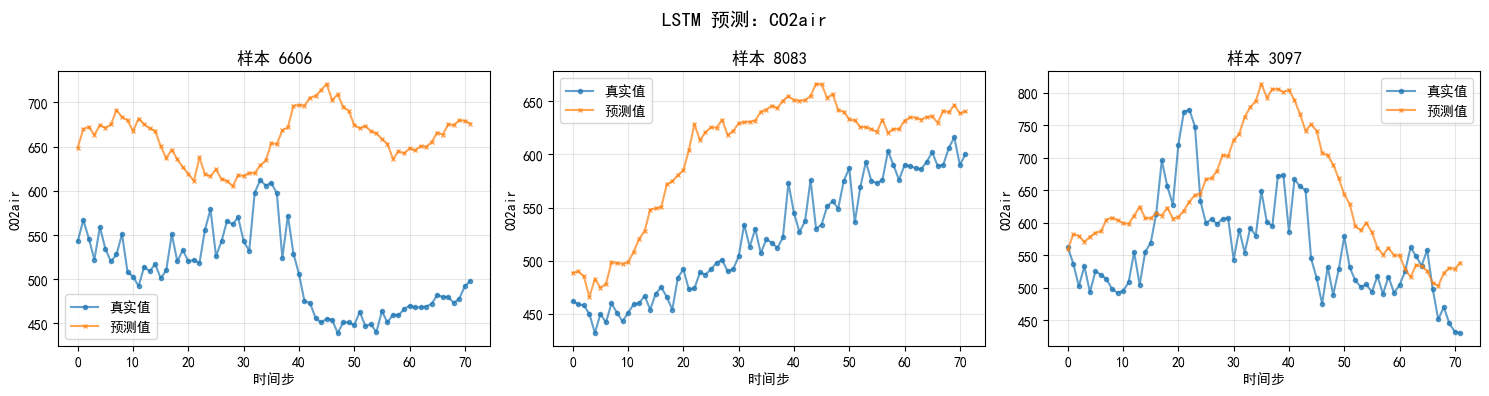

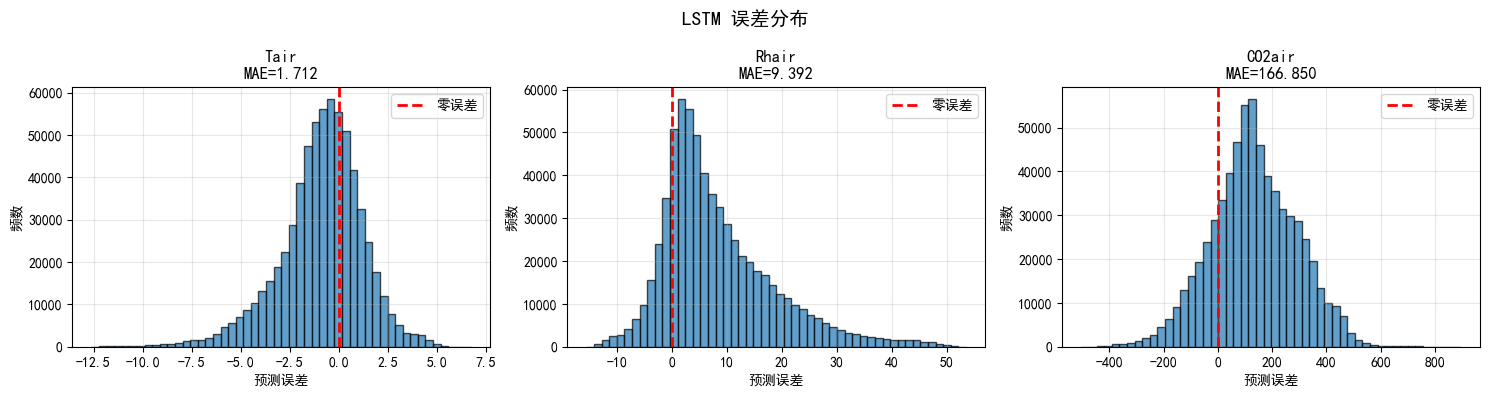

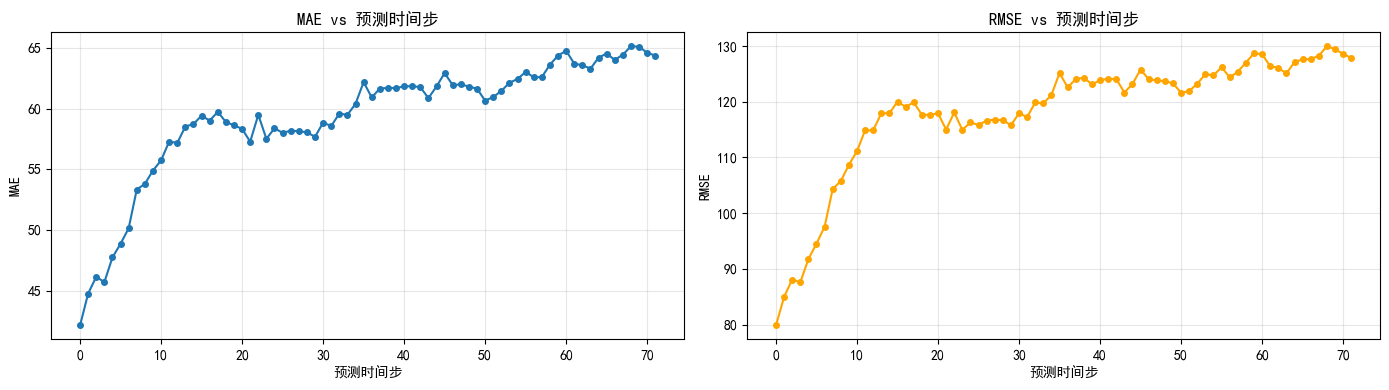


短期预测（前 12 步）MAE: 50.0367
长期预测（后 12 步）MAE: 64.3190


In [8]:
model_name = "LSTM"

# ========= 7. 预测结果可视化 =========
# 随机选择几个样本进行可视化
n_samples = min(3, len(y_true))
# 固定随机种子以便复现，或者完全随机
rng = np.random.default_rng()
sample_indices = rng.choice(len(y_true), n_samples, replace=False)

for var_idx, var_name in enumerate(target_cols):
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 4))
    if n_samples == 1:
        axes = [axes]
    
    for ax, sample_idx in zip(axes, sample_indices):
        ax.plot(y_true_raw[sample_idx, :, var_idx], label='真实值', marker='o', markersize=3, alpha=0.7)
        ax.plot(y_pred_raw[sample_idx, :, var_idx], label='预测值', marker='x', markersize=3, alpha=0.7)
        ax.set_title(f'样本 {sample_idx}')
        ax.set_xlabel('时间步')
        ax.set_ylabel(var_name)
        ax.legend()
        ax.grid(alpha=0.3)
    
    fig.suptitle(f'{model_name} 预测：{var_name}', fontsize=14)
    plt.tight_layout()
    save_figure(fig, run_dir / 'figures' / f'pred_curve_{var_name}.png')
    plt.show()

# ========= 8. 误差分布分析 =========
# 计算每个目标变量的误差
errors = y_pred_raw - y_true_raw  # [N, pred_len, target_dim]

fig, axes = plt.subplots(1, len(target_cols), figsize=(5 * len(target_cols), 4))
if len(target_cols) == 1:
    axes = [axes]

for ax, (var_idx, var_name) in zip(axes, enumerate(target_cols)):
    var_errors = errors[:, :, var_idx].flatten()
    ax.hist(var_errors, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='零误差')
    ax.set_title(f'{var_name}\nMAE={np.abs(var_errors).mean():.3f}')
    ax.set_xlabel('预测误差')
    ax.set_ylabel('频数')
    ax.legend()
    ax.grid(alpha=0.3)

fig.suptitle(f'{model_name} 误差分布', fontsize=14)
plt.tight_layout()
save_figure(fig, run_dir / 'figures' / 'error_distribution.png')
plt.show()

# ========= 9. 按时间步的预测性能 =========
# 计算每个时间步的平均误差
mae_per_step = np.abs(errors).mean(axis=(0, 2))  # [pred_len]
rmse_per_step = np.sqrt((errors ** 2).mean(axis=(0, 2)))  # [pred_len]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(mae_per_step, marker='o', markersize=4)
axes[0].set_title('MAE vs 预测时间步')
axes[0].set_xlabel('预测时间步')
axes[0].set_ylabel('MAE')
axes[0].grid(alpha=0.3)

axes[1].plot(rmse_per_step, marker='o', markersize=4, color='orange')
axes[1].set_title('RMSE vs 预测时间步')
axes[1].set_xlabel('预测时间步')
axes[1].set_ylabel('RMSE')
axes[1].grid(alpha=0.3)

plt.tight_layout()
save_figure(fig, run_dir / 'figures' / 'error_per_step.png')
plt.show()

print(f'\n短期预测（前 12 步）MAE: {mae_per_step[:12].mean():.4f}')
print(f'长期预测（后 12 步）MAE: {mae_per_step[-12:].mean():.4f}')